> **IMPORTANT**: Before running this notebook, ensure you have ran:
> ```bash
> python ./scripts/preprocessing/preprocess_data.py
> ``` 
> You will know if you ran this if you see a `pickled_objects` folder in your root directory. This folder will be used to load in preprocessed data and the saved preprcoessor.

# Import Libraries

In [1]:
from utils.preprocessing import load_preprocessed_data, load_preprocessor
from models.mlp import MLP, Trainer, ASLDataset, plot_history
from models.sklearn import SklearnClassifier, load_model
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from typing import Literal
from collections import defaultdict

In [2]:
# Define dictionary for scores
models = defaultdict(dict[Literal['val_accuracy', 'test_accuracy'], float]) 

# Get Data and Preprocesssor

In [3]:
train_data = load_preprocessed_data('train')
val_data = load_preprocessed_data('val')
test_data = load_preprocessed_data('test')
preprocessor = load_preprocessor()

# Train Models

## KNN

### Train and Evaluate Model

In [4]:
knn = SklearnClassifier(
    classifier=KNeighborsClassifier(n_neighbors=4),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
knn.fit(model_name='knn')

# Get cross val score
val_score_knn = knn.val_acc_score()
models['KNN']['val_accuracy'] = val_score_knn
print(f'KNN Validation Score: {val_score_knn:.4f}')

# Get test score
test_score_knn = knn.test_acc_score()
models['KNN']['test_accuracy'] = test_score_knn
print(f'KNN Test Score: {test_score_knn:.4f}')

Saved knn to pickled_objects/knn.pkl
KNN Validation Score: 0.9833
KNN Test Score: 0.9799


### Load in Pickled Model

In [5]:
knn = load_model('knn')
knn

KNeighborsClassifier(n_neighbors=4)

### Get Classification Report

In [6]:
y_true = test_data[-1]
y_pred = knn.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.93      0.98      0.96       300
           B       0.97      0.98      0.98       300
           C       1.00      0.99      0.99       300
           D       0.98      1.00      0.99       300
           E       0.94      0.95      0.95       300
           F       0.99      0.96      0.98       300
           G       1.00      0.99      1.00       300
           H       0.99      1.00      1.00       300
           I       0.98      0.99      0.99       300
           J       0.99      1.00      0.99       300
           K       0.98      0.98      0.98       300
           L       0.98      0.99      0.99       300
           M       0.98      0.97      0.98       300
           N       1.00      0.99      1.00       300
           O       1.00      0.99      0.99       300
           P       1.00      0.99      0.99       300
           Q       0.99      1.00      1.00       300
           R       0.93    

### Make Predictions

In [7]:
def make_sklearn_predictions(classifier: SklearnClassifier, n_samples: int) -> None:
    """
    Predicts and evaluates random test samples using a SklearnClassifier instance.

    Args:
        classifier (SklearnClassifier): An instance of SklearnClassifier with a fitted classifier.
        n_samples (int): Number of random test samples to predict and evaluate.
    """
    random_idxs = np.random.randint(0, len(test_data[0]), n_samples)
    
    trues = []
    preds = []
    
    for idx in random_idxs:
        X_test = test_data[0][idx].reshape(1, -1)  
        y_true = test_data[-1][idx]
        pred = classifier.predict(X_test).item()
        preds.append(pred)
        trues.append(y_true)
        pred_label = preprocessor.label_encoder.inverse_transform([pred])
        true_label = preprocessor.label_encoder.inverse_transform([y_true])
        print(f'True: {true_label}, Pred: {pred_label}')
    
    print('*' * 50)
    accuracy = accuracy_score(y_true=np.array(trues), y_pred=np.array(preds))
    print(f'Accuracy for {n_samples} random test samples: {accuracy:.2f}')


make_sklearn_predictions(classifier=knn, n_samples=20)

True: ['Y'], Pred: ['Y']
True: ['A'], Pred: ['A']
True: ['Z'], Pred: ['Z']
True: ['B'], Pred: ['B']
True: ['nothing'], Pred: ['nothing']
True: ['X'], Pred: ['X']
True: ['F'], Pred: ['F']
True: ['Q'], Pred: ['Q']
True: ['F'], Pred: ['F']
True: ['H'], Pred: ['H']
True: ['Z'], Pred: ['Z']
True: ['V'], Pred: ['V']
True: ['J'], Pred: ['J']
True: ['U'], Pred: ['U']
True: ['L'], Pred: ['L']
True: ['D'], Pred: ['D']
True: ['P'], Pred: ['P']
True: ['J'], Pred: ['J']
True: ['M'], Pred: ['M']
True: ['del'], Pred: ['del']
**************************************************
Accuracy for 20 random test samples: 1.00


## Random Forest

### Fit and Evaluation Model

In [8]:
rf = SklearnClassifier(
    classifier=RandomForestClassifier(n_estimators=50),
    train_data=train_data,
    val_data=val_data,
    test_data=test_data
)

# Fit model
rf.fit(model_name='random_forest')

# Get cross val score
val_score_rf = rf.val_acc_score()
models['Random Forest']['val_accuracy'] = val_score_rf
print(f'Random Forest Validation Score: {val_score_rf:.4f}')

# Get test score
test_score_rf = rf.test_acc_score()
models['Random Forest']['test_accuracy'] = test_score_rf
print(f'Random Forest Test Score: {test_score_rf:.4f}')

Saved random_forest to pickled_objects/random_forest.pkl
Random Forest Validation Score: 0.9878
Random Forest Test Score: 0.9866


### Load in Pickled Model

In [9]:
rf = load_model('random_forest')
rf

RandomForestClassifier(n_estimators=50)

### Get Classification Report

In [10]:
y_true = test_data[-1]
y_pred = rf.predict(test_data[0])
y_true_labels = preprocessor.label_encoder.inverse_transform(y=y_true)
y_pred_labels = preprocessor.label_encoder.inverse_transform(y=y_pred)
report = classification_report(y_true=y_true_labels, y_pred=y_pred_labels)
print(report)

              precision    recall  f1-score   support

           A       0.99      0.96      0.97       300
           B       0.97      0.93      0.95       300
           C       0.99      0.99      0.99       300
           D       0.95      0.99      0.97       300
           E       0.96      0.96      0.96       300
           F       0.99      0.99      0.99       300
           G       1.00      0.99      0.99       300
           H       1.00      1.00      1.00       300
           I       1.00      1.00      1.00       300
           J       0.99      1.00      0.99       300
           K       1.00      1.00      1.00       300
           L       0.99      1.00      1.00       300
           M       0.97      0.99      0.98       300
           N       1.00      1.00      1.00       300
           O       0.99      0.98      0.98       300
           P       1.00      1.00      1.00       300
           Q       1.00      1.00      1.00       300
           R       1.00    

### Make Predictions

In [11]:
make_sklearn_predictions(classifier=rf, n_samples=20)

True: ['space'], Pred: ['space']
True: ['V'], Pred: ['V']
True: ['C'], Pred: ['C']
True: ['A'], Pred: ['A']
True: ['Y'], Pred: ['Y']
True: ['X'], Pred: ['X']
True: ['nothing'], Pred: ['nothing']
True: ['G'], Pred: ['G']
True: ['I'], Pred: ['I']
True: ['T'], Pred: ['T']
True: ['U'], Pred: ['U']
True: ['T'], Pred: ['T']
True: ['nothing'], Pred: ['nothing']
True: ['E'], Pred: ['E']
True: ['J'], Pred: ['J']
True: ['I'], Pred: ['I']
True: ['X'], Pred: ['X']
True: ['H'], Pred: ['H']
True: ['V'], Pred: ['V']
True: ['Y'], Pred: ['Y']
**************************************************
Accuracy for 20 random test samples: 1.00


## MLP

### Initialize Network

In [12]:
input_dim = train_data[0].shape[-1]
output_dim = len(np.unique(train_data[-1]))
model = MLP(input_dim=input_dim, output_dim=output_dim)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=12288, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=29, bias=True)
  )
)


### Initialize Trainer

In [13]:
trainer = Trainer(
    model=model,
    optimizer=optim.Adam,
    learning_rate=5e-4,
    loss_fn=nn.CrossEntropyLoss(),
    dataset_cls=ASLDataset,
    train_data=train_data,
    val_data=val_data,
    test_data=test_data,
    batch_size=32,
    num_epochs=100,
    patience=4
)

### Train Model

In [14]:
history = trainer.train()

Epoch 1/100:


Val Loss: 1.2531, Val Acc: 0.5463: 100%|██████████| 272/272 [00:01<00:00, 193.93it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 2/100:


Val Loss: 0.7086, Val Acc: 0.7431: 100%|██████████| 272/272 [00:01<00:00, 205.38it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 3/100:


Val Loss: 0.5404, Val Acc: 0.7975: 100%|██████████| 272/272 [00:01<00:00, 213.42it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 4/100:


Val Loss: 0.3745, Val Acc: 0.8536: 100%|██████████| 272/272 [00:01<00:00, 209.38it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 5/100:


Val Loss: 0.3400, Val Acc: 0.8694: 100%|██████████| 272/272 [00:01<00:00, 198.70it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 6/100:


Val Loss: 0.2965, Val Acc: 0.8864: 100%|██████████| 272/272 [00:01<00:00, 213.34it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 7/100:


Val Loss: 0.2588, Val Acc: 0.9031: 100%|██████████| 272/272 [00:01<00:00, 213.74it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 8/100:


Val Loss: 0.3049, Val Acc: 0.8874: 100%|██████████| 272/272 [00:01<00:00, 201.89it/s]



Epoch 9/100:


Val Loss: 0.1486, Val Acc: 0.9428: 100%|██████████| 272/272 [00:01<00:00, 220.27it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 10/100:


Val Loss: 0.1341, Val Acc: 0.9521: 100%|██████████| 272/272 [00:01<00:00, 213.36it/s]


Saved best model weights to weights/best_model_checkpoint.pth

Epoch 11/100:


Val Loss: 0.2659, Val Acc: 0.8991: 100%|██████████| 272/272 [00:01<00:00, 216.59it/s]



Epoch 12/100:


Val Loss: 0.1864, Val Acc: 0.9269: 100%|██████████| 272/272 [00:01<00:00, 223.58it/s]



Epoch 13/100:


Val Loss: 0.1734, Val Acc: 0.9421: 100%|██████████| 272/272 [00:01<00:00, 213.59it/s]



Epoch 14/100:


Val Loss: 0.2026, Val Acc: 0.9251: 100%|██████████| 272/272 [00:01<00:00, 217.06it/s]


Early stopping triggered at epoch 14.
Restoring weights back to epoch 10.


### Visualize Training

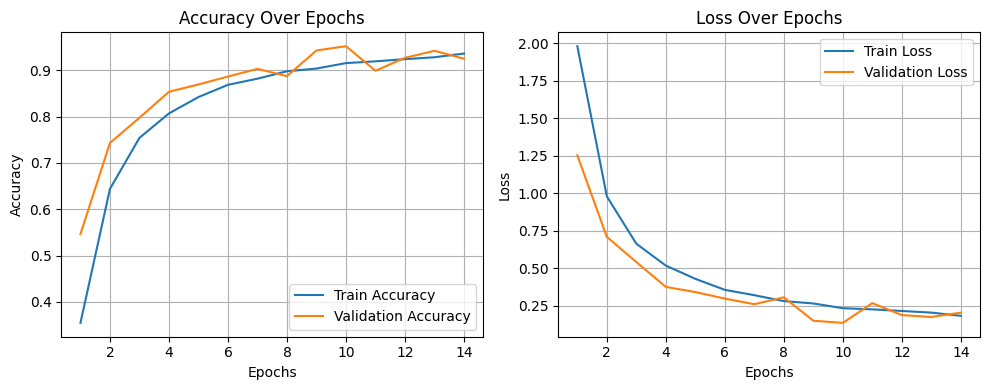

In [15]:
plot_history(history=history)

### Load in Cached Weights (only if they are not in memory)

In [16]:
trainer.load_checkpointed_weights('weights/best_model_checkpoint.pth')
trainer.batch_loaders()

Successfully loaded in weights from weights/best_model_checkpoint.pth.


### Evalaute Model on Val and Test Set 

In [17]:
val_stats = trainer.evaluate(loader_type='val')
models['MLP']['val_accuracy'] = val_stats['accuracy']

Val Loss: 0.1341, Val Acc: 0.9521: 100%|██████████| 272/272 [00:01<00:00, 157.55it/s]


In [18]:
test_stats = trainer.evaluate(loader_type='test')
models['MLP']['test_accuracy'] = test_stats['accuracy']

Test Loss: 0.1323, Test Acc: 0.9507: 100%|██████████| 272/272 [00:01<00:00, 226.87it/s]


### Get Full Classification Report

In [19]:
preds = preprocessor.label_encoder.inverse_transform(torch.cat([trainer.predict(x.reshape(1, -1)) for x in test_data[0]]).numpy())
truths = preprocessor.label_encoder.inverse_transform(test_data[-1])

In [20]:
report = classification_report(y_true=truths, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           A       0.97      0.95      0.96       300
           B       0.93      0.99      0.96       300
           C       0.97      0.98      0.97       300
           D       0.99      0.97      0.98       300
           E       0.97      0.93      0.95       300
           F       0.98      0.99      0.99       300
           G       0.99      0.99      0.99       300
           H       0.97      1.00      0.99       300
           I       0.98      0.99      0.99       300
           J       1.00      1.00      1.00       300
           K       0.96      0.99      0.97       300
           L       1.00      0.95      0.97       300
           M       0.98      0.89      0.93       300
           N       0.90      0.99      0.94       300
           O       0.96      0.96      0.96       300
           P       0.98      0.96      0.97       300
           Q       0.96      0.99      0.98       300
           R       0.99    

### Make Predictions

In [21]:
def make_mlp_predictions(n_samples: int) -> None:
    """
    Function to make n random predictions from the test data.

    Args:
        n_samples (int): Number of random test predictions.
    """
    random_idxs = np.random.randint(0, len(test_data[0]), n_samples)
    trues = []
    preds = []
    for idx in random_idxs:
        X_test = test_data[0][idx].reshape(1, -1)
        y_true = test_data[-1][idx]
        pred = trainer.predict(X_test).item()
        preds.append(pred)
        trues.append(y_true)
        pred_label = preprocessor.label_encoder.inverse_transform([pred])
        true_label = preprocessor.label_encoder.inverse_transform([y_true])
        print(f'True: {true_label}, Pred: {pred_label}')
    print('*'*50)
    print(f'Accuracy for {n_samples} random test samples: {np.mean((np.array(trues).flatten() == np.array(preds).flatten()))}')


make_mlp_predictions(20)

True: ['O'], Pred: ['O']
True: ['E'], Pred: ['E']
True: ['A'], Pred: ['A']
True: ['L'], Pred: ['L']
True: ['R'], Pred: ['R']
True: ['V'], Pred: ['V']
True: ['F'], Pred: ['F']
True: ['G'], Pred: ['G']
True: ['U'], Pred: ['U']
True: ['D'], Pred: ['D']
True: ['B'], Pred: ['B']
True: ['space'], Pred: ['space']
True: ['N'], Pred: ['N']
True: ['space'], Pred: ['space']
True: ['R'], Pred: ['S']
True: ['N'], Pred: ['N']
True: ['T'], Pred: ['T']
True: ['space'], Pred: ['space']
True: ['space'], Pred: ['space']
True: ['Y'], Pred: ['Y']
**************************************************
Accuracy for 20 random test samples: 0.95


# Compare Models

In [31]:
# Convert models DataFrame to a styled DataFrame and remove trailing zeros
models_df = pd.DataFrame(models)  # Convert to DataFrame
models_df = models_df.map(lambda x: ('%.4f' % x)).T  # Remove trailing zeros
models_df.sort_values('test_accuracy', ascending=False, inplace=True)  # Sort by test accuracy

# Highlight best model
top_model = models_df.index[0]
df_styled = models_df.style.apply(
    lambda row: ['background-color: green' if row.name == top_model else '' for _ in row], axis=1
)
df_styled

,val_accuracy,test_accuracy
Random Forest,0.9878,0.9866
KNN,0.9833,0.9799
MLP,0.9521,0.9507
